In [1]:
%pip install pandas
%pip install sklearn
%pip install matplotlib
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Librerias

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Label Mappings
| a | b | c | d | e | f | g | h | i | k  | l  | m  | n  | o  | p  | q  | r  | s  | t  | u  | v  | w  | x  | y  | z |
|---|---|---|---|---|---|---|---|---|---|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
| 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 |

In [5]:
mappings = np.array(["a","b","c","d","e","f","g","h","i","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"])

In [102]:
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np
from scipy import spatial

class KNN_LDA(BaseEstimator):
    
    def __init__(self, n_comps=1, k=3):
        self.n_comps = n_comps
        self.k = k
        pass

    def fit(self, X, y, **kwargs):
        if y is None:
            raise ValueError('requires y to be passed, but the target y is None')

        X, y = check_X_y(X, y)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]
        
        self.es_lda_model_ = LDA(n_components=self.n_comps)
        es_lda = self.es_lda_model_.fit_transform(X,y.ravel())
        print("trainlda:\n",es_lda)
        self.es_kd_tree_ = spatial.KDTree(es_lda)
        self.y_ = y
        return self
        
    def es_query_get_expressions(self, kd_tree, x_list_validation, y_list, k):
        d,i = kd_tree.query(x_list_validation, k)
        expression_list = y_list[i]
        return d, expression_list.flatten()

    def predict(self, X):
        check_is_fitted(self, 'is_fitted_')
        X = check_array(X)

        es_tf_test = self.es_lda_model_.transform(X)
        print("testlda:\n",es_tf_test)
        
        y_pred_val = []
        for x_row in es_tf_test:
            distances, expressions = self.es_query_get_expressions(self.es_kd_tree_, x_row, self.y_, self.k)
            # print(expressions)
            voted_expression = max(set(expressions), key=lambda x: list(expressions).count(x))
            y_pred_val.append(voted_expression)
        return (np.array(y_pred_val))

check_estimator(KNN_LDA())

trainlda:
 [[ 0.45097563]
 [ 1.20882545]
 [ 3.35331787]
 [-4.09779727]
 [ 5.11092638]
 [ 2.10857498]
 [-2.23128322]
 [ 0.73671926]
 [-0.8410222 ]
 [ 3.73682168]
 [ 1.33271575]
 [-2.88449039]
 [-2.01586814]
 [-1.04314685]
 [ 4.70666846]
 [-2.99664166]
 [-0.95405212]
 [-1.93892586]
 [-1.35076548]
 [-2.39155224]]
testlda:
 [[ 0.45097563]
 [ 1.20882545]
 [ 3.35331787]
 [-4.09779727]
 [ 5.11092638]
 [ 2.10857498]
 [-2.23128322]
 [ 0.73671926]
 [-0.8410222 ]
 [ 3.73682168]
 [ 1.33271575]
 [-2.88449039]
 [-2.01586814]
 [-1.04314685]
 [ 4.70666846]
 [-2.99664166]
 [-0.95405212]
 [-1.93892586]
 [-1.35076548]
 [-2.39155224]]
trainlda:
 [[ 0.45097563]
 [ 1.20882545]
 [ 3.35331787]
 [-4.09779727]
 [ 5.11092638]
 [ 2.10857498]
 [-2.23128322]
 [ 0.73671926]
 [-0.8410222 ]
 [ 3.73682168]
 [ 1.33271575]
 [-2.88449039]
 [-2.01586814]
 [-1.04314685]
 [ 4.70666846]
 [-2.99664166]
 [-0.95405212]
 [-1.93892586]
 [-1.35076548]
 [-2.39155224]]
testlda:
 [[ 0.45097563]
 [ 1.20882545]
 [ 3.35331787]
 [-4.09779

In [61]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cnf_matrix(Y_test, Y_pred):
  cnf_matrix = confusion_matrix(Y_test, Y_pred)

  # f = sns.heatmap(cnf_matrix, annot=True, fmt='d')
  cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

  plt.rcParams['figure.figsize'] = (20, 10)
  ax= plt.subplot()
  sns.heatmap(cnf_matrix, annot=True, fmt='.2f', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 

In [70]:
# from sklearn.preprocessing import StandardScaler
sign_df = pd.read_csv("dataset/sign_mnist_full.csv")

sign_X = sign_df.loc[:,  sign_df.columns != "label"].values
sign_Y = sign_df.loc[:,["label"]].values

# SS = StandardScaler()
# x = SS.fit_transform(x)
# x = pd.DataFrame(x)

In [93]:
sign_df_train = pd.read_csv("dataset/sign_mnist_train.csv")

sign_X_train = sign_df.loc[:,  sign_df.columns != "label"].values
sign_Y_train = sign_df.loc[:,["label"]].values

sign_df_test = pd.read_csv("dataset/sign_mnist_test.csv")

sign_X_test = sign_df_test.loc[:,  sign_df_test.columns != "label"].values
sign_Y_test = sign_df_test.loc[:,["label"]].values

In [ ]:
# modl = KNN_LDA(21,6)
# modl.fit(X=x, y=y.ravel())
# yxd = modl.predict(x_test)

In [ ]:
# cnf_matrix = confusion_matrix(y_test, yxd)
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# # f = sns.heatmap(cnf_matrix, annot=True, fmt='d')
# cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

# plt.rcParams['figure.figsize'] = (20, 10)
# ax= plt.subplot()
# sns.heatmap(cnf_matrix, annot=True, fmt='.2f', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
# # ax.xaxis.set_ticklabels(["neutral", "surprise", "sad", "disgust", "fear", "happy", "angry"]); ax.yaxis.set_ticklabels(["neutral", "surprise", "sad", "disgust", "fear", "happy", "angry"]);


In [109]:
from xml.etree.ElementInclude import include
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, precision_score,roc_auc_score
from sklearn.metrics import classification_report
import numpy as np
import itertools

def KFold_KNN(X_, Y_, k_splits_ = 10, n_comps_ = 20, k_ = 3):
  # kf = KFold(n_splits=k_splits_, random_state=False, shuffle=False)
  kf = KFold(n_splits=k_splits_)

  # split = 0
  precision = recall = f1 = AUC = 0
  for train_index, test_index in kf.split(X_):
    X_train, X_test = X_[train_index, :], X_[test_index, :] 
    Y_train, Y_test = Y_[train_index], Y_[test_index]

    Scaler = StandardScaler()
    X_train = Scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train)
    X_test = Scaler.transform(X_test)
    X_test = pd.DataFrame(X_test)
    print(X_train.head())
    break
  
    model = KNN_LDA(n_comps_,k_)
    model.fit(X=X_train, y=Y_train.ravel())
    Y_predicted = model.predict(X_test)
    print(Y_test.ravel())
    print(Y_predicted)      
    
    # metrics

    precision += precision_score(Y_test, Y_predicted, average="weighted")
    recall += recall_score(Y_test, Y_predicted, average="weighted")
    f1 += f1_score(Y_test, Y_predicted,  average="weighted")

    # y_true = [0, 1, 2, 2, 2]
    # y_pred = [0, 0, 2, 2, 1]
    # target_names = ['class 0', 'class 1', 'class 2']
    # print(classification_report(Y_test, Y_predicted))

    # "AUC:", roc_auc_score(Y_test, Y_predicted, multi_class='ovr'))
    # split += 1
  precision /= k_splits_
  recall /= k_splits_
  f1 /= k_splits_
  AUC /= k_splits_

  print(f"Final metrics ({k_splits_}-Fold, {n_comps_}-LDA vectors, {k_}-NN search)\n", 
  "Precision:", "{:.2f}".format(precision),
  " | Recall:", "{:.2f}".format(recall), 
  " | F1:", "{:.2f}".format(f1))

KFold_KNN(sign_X, sign_Y, 2, 21, 6)

        0         1         2         3         4         5         6    \
0  0.112379  0.063916  0.046154  0.012854 -0.059137 -0.092555 -0.124672   
1  0.014382 -0.037638 -0.109517 -0.144502 -0.168238 -0.232224 -0.297228   
2  0.577869  0.546297  0.487222  0.406243  0.349994  0.298516  0.220439   
3  0.381873  0.444743  0.487222  0.511147  0.540921  0.521986  0.565549   
4  0.112379  0.063916  0.020209 -0.039598 -0.113687 -0.176356 -0.239709   

        7         8         9    ...       774       775       776       777  \
0 -0.214350 -0.237457 -0.300021  ...  0.029844  0.583086  0.362966  0.275222   
1 -0.363868 -0.452549 -0.525041  ...  0.468423  0.355303  0.255163  0.181548   
2  0.204299  0.100545  0.021437  ... -0.361745 -0.662125 -1.023076  0.056650   
3  0.622949  0.622912  0.632206  ...  0.061171 -0.176189 -0.222252  1.009000   
4 -0.333965 -0.360366 -0.428604  ... -0.064138  0.750127  0.547772  0.478182   

        778       779       780       781       782       783  
0  0

[[  2.26320808  -0.17007168  -1.90595956 ...   2.77680496  -0.4941363
    0.04561653]
 [  2.75700526  -2.30645302   3.03943387 ...  -1.11102034   1.2412091
    0.23560604]
 [ -1.47563704 -10.22877186   0.4899658  ...   0.28041795  -2.25062652
   -0.73437608]
 ...
 [ -2.67238154   2.01693256  -0.5964472  ...  -0.5864337   -2.67486869
    0.59963928]
 [  3.22122243  -0.10667176  -0.82353631 ...  -0.17938239  -0.19081348
   -0.91437483]
 [  4.65809503  -0.35124956   0.57843709 ...  -1.19354342  -2.1426492
    1.68031289]]
[ 6  5 10 ...  2  4  2]
[20 10 10 ... 14  4 14]
Final metrics (0-Fold, 21-LDA vectors, 6-NN search)
 Precision: 0.48  | Recall: 0.44  | F1: 0.45


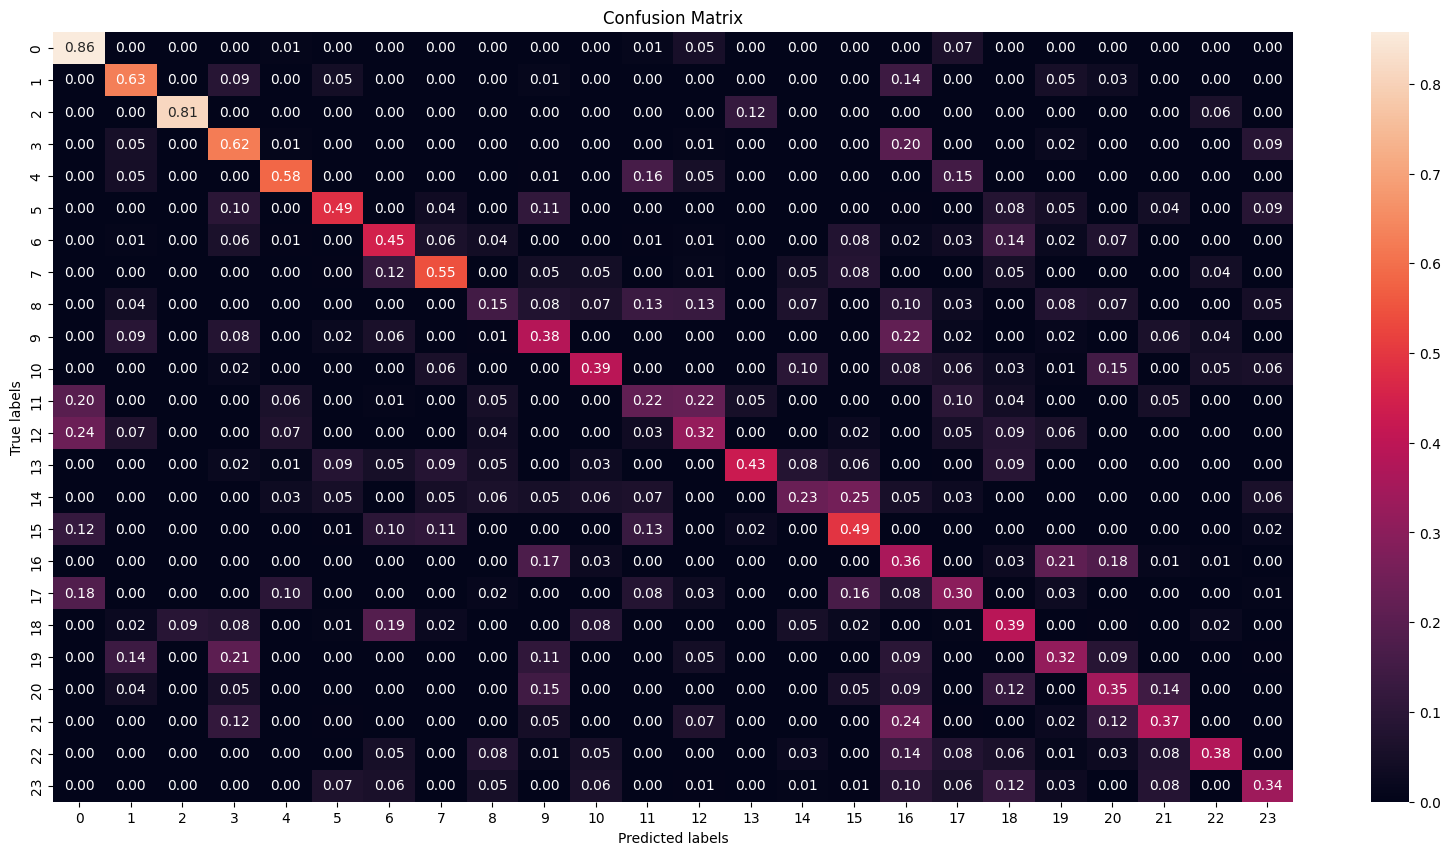

In [97]:
from xml.etree.ElementInclude import include
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, precision_score,roc_auc_score
from sklearn.metrics import classification_report
import numpy as np
import itertools

from sklearn.model_selection import train_test_split

def split_KNN(X_, Y_, k_splits_ = 10, n_comps_ = 20, k_ = 3):
  # kf = KFold(n_splits=k_splits_, random_state=42, shuffle=True)
  # kf = KFold(n_splits=k_splits_)

  # split = 0
  precision = recall = f1 = AUC = 0
  # X_train, X_test, Y_train, Y_test = train_test_split(X_, Y_, test_size=0.2, random_state=42)
  X_train, X_test, Y_train, Y_test = sign_X_train, sign_X_test,sign_Y_train,sign_Y_test


    # X_train, X_test = X_[train_index, :], X_[test_index, :] 
    # Y_train, Y_test = Y_[train_index], Y_[test_index]

  Scaler = StandardScaler()
  X_train = Scaler.fit_transform(X_train)
  X_train = pd.DataFrame(X_train)

  X_test = Scaler.transform(X_test)
  X_test = pd.DataFrame(X_test)
  # print(X_test.head())
  # return 
  model = KNN_LDA(n_comps_,k_)
  model.fit(X=X_train, y=Y_train.ravel())
  Y_predicted = model.predict(X_test)

  np.set_printoptions(threshold=300)
  print(Y_test.ravel())
  print(Y_predicted)      
  # metrics
  precision += precision_score(Y_test, Y_predicted, average="weighted")
  recall += recall_score(Y_test, Y_predicted, average="weighted")
  f1 += f1_score(Y_test, Y_predicted,  average="weighted")

  # precision /= k_splits_
  # recall /= k_splits_
  # f1 /= k_splits_
  # AUC /= k_splits_

  print(f"Final metrics ({0}-Fold, {n_comps_}-LDA vectors, {k_}-NN search)\n", 
  "Precision:", "{:.2f}".format(precision),
  " | Recall:", "{:.2f}".format(recall), 
  " | F1:", "{:.2f}".format(f1))
  
  plot_cnf_matrix(Y_test, Y_predicted)


split_KNN(sign_X, sign_Y, 20, 21, 6)

# TODO-> CHECK WHY KNN_LDA() IMPLEMENTATION IS DIFFERENT


7172
7172
Final metrics (0-Fold, 21-LDA vectors, 6-NN search)
 Precision: 0.48  | Recall: 0.44  | F1: 0.45


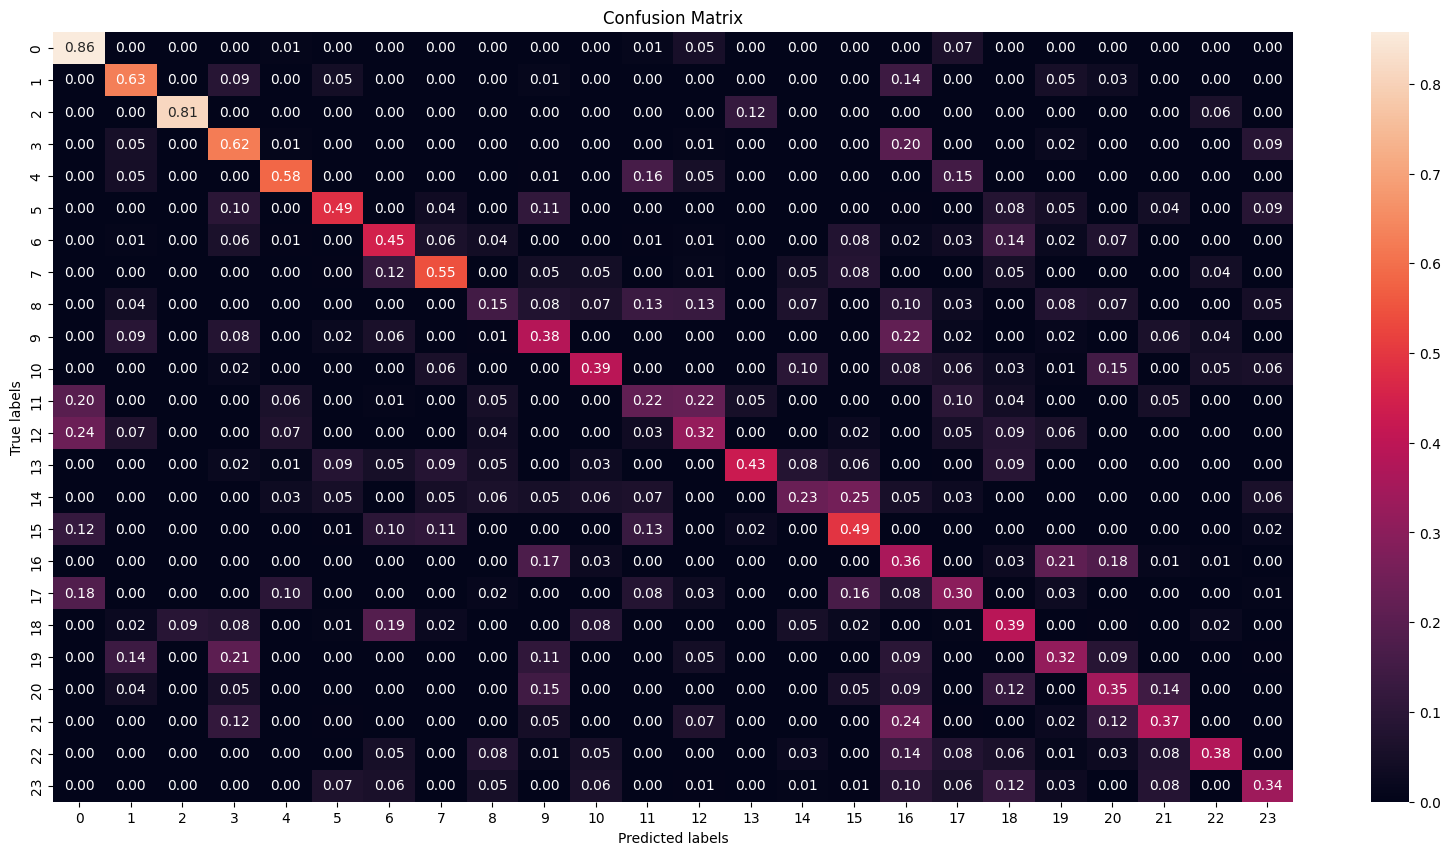

In [96]:
from xml.etree.ElementInclude import include
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, precision_score,roc_auc_score
from sklearn.metrics import classification_report
import numpy as np
import itertools
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


from sklearn.model_selection import train_test_split

def query_get_expressions(kd_tree, x_list_validation, y_list, k=3):
  d,i = kd_tree.query(x_list_validation,k)
  expression_list = y_list[i]

  return d, expression_list.flatten()

def startingKNN(X_, Y_, k_splits_ = 10, n_comps_ = 20, k_ = 3):
  # kf = KFold(n_splits=k_splits_, random_state=False, shuffle=False)
  
  df = pd.read_csv("dataset/sign_mnist_train.csv")
  df
  from sklearn.preprocessing import StandardScaler
  x = df.loc[:,  df.columns != "label"].values
  y = df.loc[:,["label"]].values

  SS = StandardScaler()
  x = SS.fit_transform(x)
  x = pd.DataFrame(x)

  lda_model = LDA(n_components=21)
  lda = lda_model.fit_transform(x,y.ravel())
  
  kd_tree = spatial.KDTree(lda)

  df_test = pd.read_csv("dataset/sign_mnist_test.csv")
  df_test

  x_test = df_test.loc[:,  df_test.columns != "label"].values
  y_test = df_test.loc[:,["label"]].values

  x_test = SS.transform(x_test)
  x_test = pd.DataFrame(x_test)
  # print(x_test.head())
  # return

  tf_test = lda_model.transform(x_test)

  y_pred_val = []
  for x_row in tf_test:
    # print(x_row)
    # tf = lda_model.transform([x_row])
    distances, expressions = query_get_expressions(kd_tree, x_row, y, 6)
    voted_expression = max(set(expressions), key=lambda x: list(expressions).count(x))
    y_pred_val.append(voted_expression)

  print(len(y_test))
  print(len(y_pred_val))

  precision = precision_score(y_test, y_pred_val, average="weighted")
  recall = recall_score(y_test, y_pred_val, average="weighted")
  f1 = f1_score(y_test, y_pred_val,  average="weighted")
# tf_test.shape

  # precision /= k_splits_
  # recall /= k_splits_
  # f1 /= k_splits_
  # AUC /= k_splits_

  print(f"Final metrics ({0}-Fold, {21}-LDA vectors, {6}-NN search)\n", 
  "Precision:", "{:.2f}".format(precision),
  " | Recall:", "{:.2f}".format(recall), 
  " | F1:", "{:.2f}".format(f1))
  
  plot_cnf_matrix(y_test, y_pred_val)


startingKNN(sign_X, sign_Y, 20, 5, 1)

split 2 , acc_score: 0.8988043666608907


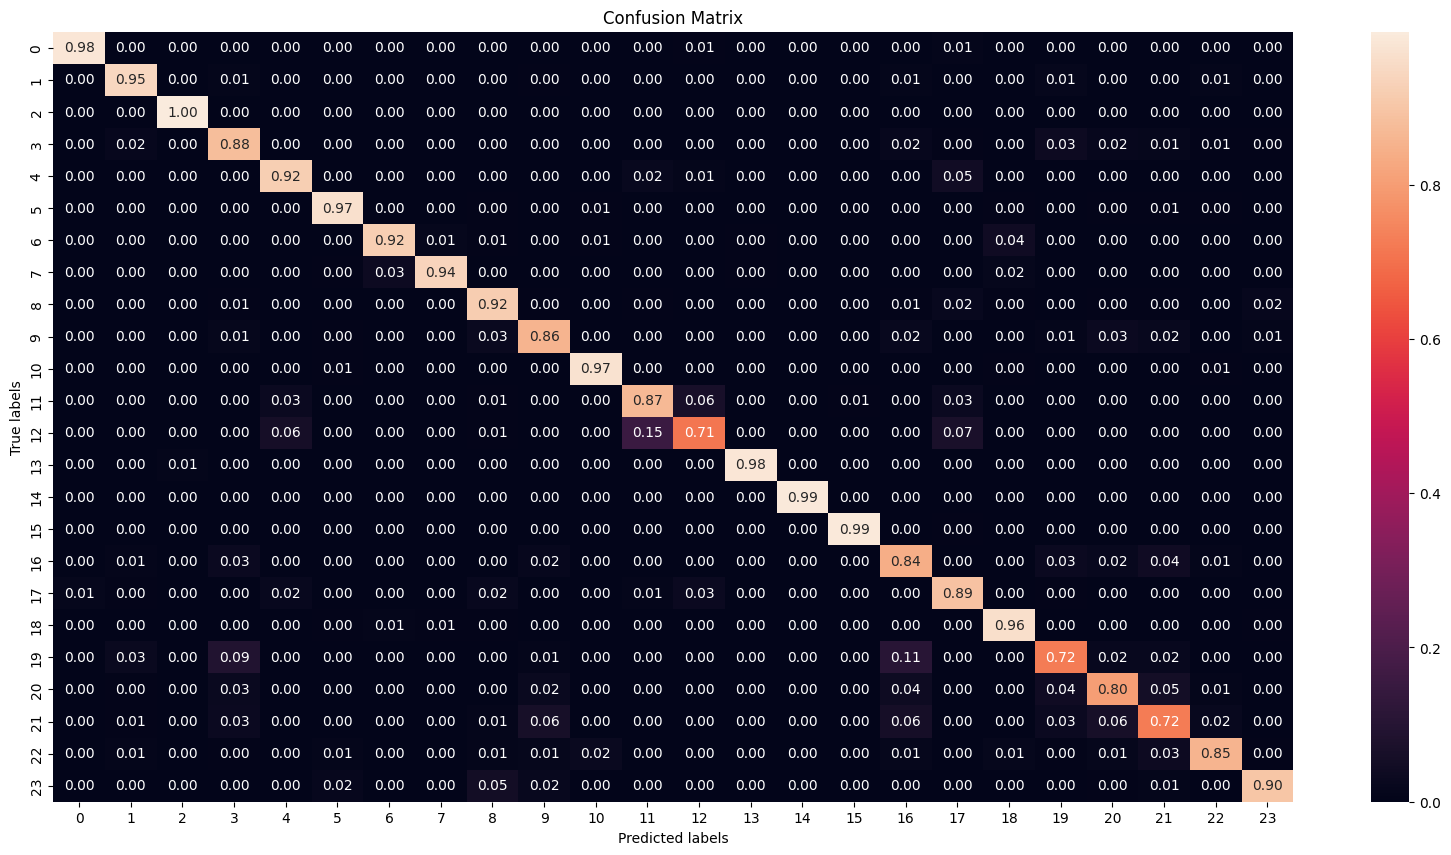

In [68]:
import matplotlib.pyplot as plt
split = 2
train_index, test_index = next(itertools.islice(kf.split(x_full), split, None))

X_train, X_test = x_full.iloc[train_index], x_full.iloc[test_index]
Y_train, Y_test = y_full[train_index], y_full[test_index]

SS_kf = StandardScaler()
X_train_SS = SS_kf.fit_transform(X_train)
X_test_SS = SS_kf.transform(X_test)
X_train_SS = pd.DataFrame(X_train_SS)
X_test_SS = pd.DataFrame(X_test_SS)
# print(X_train_SS.shape)
# 
modl = KNN(5,6)
modl.fit(X=X_train_SS, y=Y_train.ravel())

yxd = modl.predict(X_test_SS)
print("split",split,", acc_score:", accuracy_score(Y_test, yxd))


In [ ]:
print(results)